## Slides: Machine Unlearning 

Machine Unlearning 方法 (3 min)

Metric 和实验结果 (5 min)

改进 Improvement（3 min)



Machine Unlearning的目的是希望开发出更快和更有效的编辑大模型的方法，

能够**低成本，和实时**的**移除**大模型中的有害的或是不想要的信息。

Ideas of Unlearning
- 有选择的部分重新训练（exact unlearning）：retrain layers/neurons
- 设计新的 two-part objective loss函数：
    - retain信息的保留 + 对forget信息的遗忘 
    - retain error + forget penalty
- 优化和约束梯度：
  - 对retain梯度和forget梯度进行正交，特征分解
  - 基于对forget梯度的gradient ascent，减少遗忘和保留两个目的之间的干扰。


### **Selective Gradient Unlearning (SGU) 选择性梯度遗忘**

- 分别计算保留集，遗忘集上的梯度$g_r, g_f$
- 基于两个梯度的重要性和相关性，进行梯度操作（ascent，zero，descent）

define a selective function $S(g_r, g_f)$ that selects gradients based on the following criteria:

$S(g_r, g_f) = \begin{cases}
    g_r & \text{if } g_r \cdot g_f < 0 \\
    g_r & \text{if } g_r \cdot g_f \geq 0 \text{ and } |g_r| - |g_f| > \tau_d \\
    - g_f & \text{if } g_r \cdot g_f \geq 0 \text{ and } |g_f| - |g_r| > \tau_m 
      \space \text{Optional} \\
    0 & \text{otherwise} 
\end{cases}$

where $\tau_d$ is adaptive thresholds determined by quantiles of the gradient differences and magnitudes, respectively, in each batch.

1. **负相关 (gr · gf < 0)**：
   -  保留集梯度和遗忘集梯度冲突。选择保留集梯度更新模型，同时能远离遗忘集方向

2. **正相关且保留梯度重要 (gr · gf ≥ 0 且 |gr| - |gf| > \tau_d)**：
   - 梯度方向一致，但保留梯度明显更大。选择保留梯度，来保留重要的特征，保证模型在保留信息上的performance

3. **可选：正相关且遗忘梯度重要**
   - 也可以对于较大的遗忘集梯度进行梯度上升，这样做可以提高遗忘的效率，但有可能会牺牲模型的性能。

4. **默认情况**：
   - 重要性相似或不明确时，将梯度置零。

### Class-wise unlearn: Cifar10 and Tiny imagenet
- ViT-base: Pretrained on imageNet-21k, Fine-Tuned on imageNet-1k
- Unseen set: Cifar100
- **Cifar10** 
    - forget: 5000 retain: 45000
- **Tiny imagenet**
    - 200 classes
    - forget: 500 retain: 99500 


#### **Unlearning Quality - MIA Rate**

  $\text{MIA Rate = True Non-member Rate} = \frac{\text{True Predicted Non-members}}{\text{Actual Non-members}}$
- **High MIA Rate-forget**  
  - Attackers identify More forgotten samples as non-members
  - **Result:** more **successful** Unlearning

MIA rate 接近 1 代表 unseen data, 接近 0 代表 training data
- **Expected**
    -  MIA-forget ↑ (trained) -> (unlearned) 
- **Actual**
    - cifar10: MIA-forget ↑ **0.003** ->  **0.459**  
    - tiny imagenet: MIA-forget ↑ **0.024** ->  **0.228** 




In [22]:
#cifar10
compare_mia_scores(model_list, model_names, forget_loader, retain_loader, unseen_loader)

cross validation:
             true nonmember / actual nonmembers is 0.984.
             total false rate is 0.011
successful membership inference attack on cross validation, This attack model can be appllied to forgotten data
Average true non-member / actual non-members of cross validation is 0.004

pre-trained on D: 
The MIA socre is 0.003 on forgotten data
The MIA socre is 0.978 on unseen data
The MIA socre is 0.000 on seen data


cross validation:
             true nonmember / actual nonmembers is 0.978.
             total false rate is 0.014
successful membership inference attack on cross validation, This attack model can be appllied to forgotten data
Average true non-member / actual non-members of cross validation is 1.000

retrain on D_{-f}: 
The MIA socre is 1.000 on forgotten data
The MIA socre is 0.968 on unseen data
The MIA socre is 0.000 on seen data


cross validation:
             true nonmember / actual nonmembers is 0.959.
             total false rate is 0.027
successf

In [ ]:
# tiny imagenet
compare_mia_scores(modellist, modelname, forget_loader, retain_loader, unseen_loader)

cross validation:
             true nonmember / actual nonmembers is 0.909.
             total false rate is 0.071
successful membership inference attack on cross validation, This attack model can be appllied to forgotten data
Average true non-member / actual non-members of cross validation is 0.023

trained on D: 
The MIA socre is 0.024 on forgotten data
The MIA socre is 0.969 on unseen data
The MIA socre is 0.000 on seen data


cross validation:
             true nonmember / actual nonmembers is 0.879.
             total false rate is 0.086
This membership inference attack on cross validation is unsuccessful, so it should be appllied to forgotten data
Average true non-member / actual non-members of cross validation is 0.224

unlearned: 
The MIA socre is 0.228 on forgotten data
The MIA socre is 0.969 on unseen data
The MIA socre is 0.000 on seen data




#### Unlearning Quality - Entropy of Output

**Low Entropy:** 表示高置信度 (预测有更大的确定性).

在unlearn之后，
- 模型对forget data的预测更加分散在不同entropy部分，
- 相比于训练数据的集中在low entropy，整体的分布更接近unseen data。

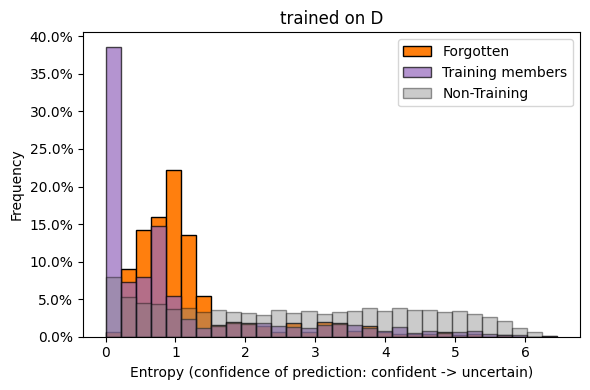

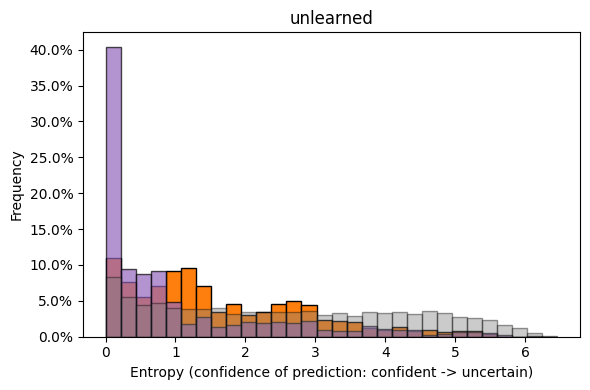

In [ ]:
# tiny imagenet
compare_entropy(modellist, modelname, [forget_loader, retain_loader, unseen_loader])

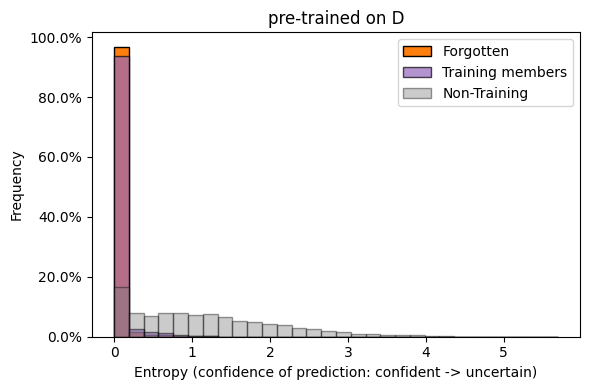

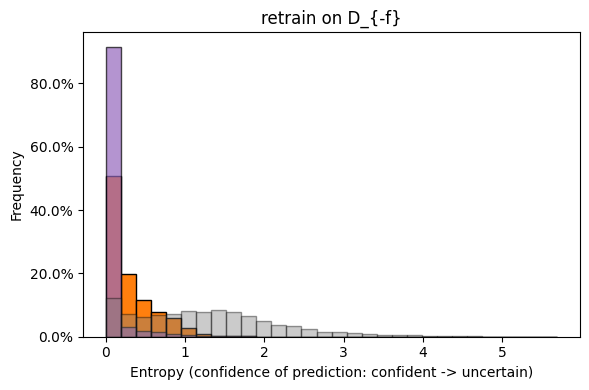

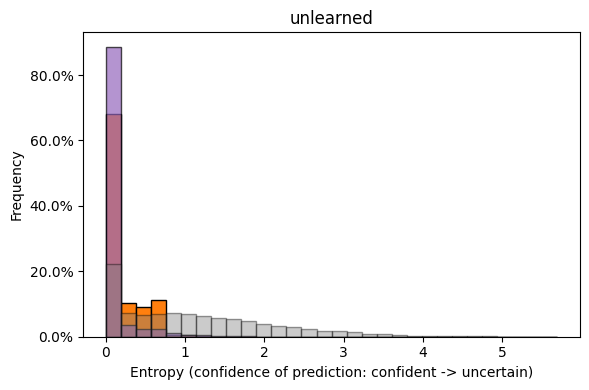

In [ ]:
# cifar10
compare_entropy(model_list, model_names, [forget_loader, retain_loader, unseen_loader])

#### Model Utility - Accuracy

In [ ]:
# tiny imagenet
compare_accuracy(modellist, modelname, forget_loader, retain_loader, test_loader, unseen_loader)

                              trained on D        unlearned           
Top1 acc on retain set        62.50%              68.50%              
Top1 acc on forget set        59.00%              2.80%               
Top1 acc on test set          62.91%              64.26%              
Top1 acc on unseen set        0.00%               0.00%               


In [ ]:
# cifar10
compare_accuracy(model_list, model_names, forget_loader, retain_loader, test_loader, unseen_loader)

                              pre-trained on D    retrain on D_{-f}   unlearned           
Top1 acc on retain set        98.37%              98.19%              95.73%              
Top1 acc on forget set        99.36%              0.00%               34.34%              
Top1 acc on test set          96.81%              87.25%              88.11%              
Top1 acc on unseen set        1.48%               1.03%               1.40%               


In [ ]:
unlearn_efficiency(res)

# cifar10
Unlearned Achieved Epoch: 1  | Passed Samples: 512
 
# tiny imagenet
Unlearned Achieved Epoch: 1 |  Passed Samples: 448

#### 改进 improvement 
- 传统 ML metric 评价 LLM 的 unlearn 的局限
	- 无法区分
		- Reject: hidden classifier，拒绝给出正确答案，遗忘的知识容易恢复
		- Unlearn: 遗忘的知识无法恢复，需要重新学习
	- 新的的 metric 
		- Memorization level of info in LLM: 
			- **rate = prompt / target output**
		- Relearn attack 
- 目前的state of art unlearning 方法的局限
	- 缺乏解释性 （model behave like forgetting）
	- Unlearning is mostly shallow 
		[Unlearning via RMU is mostly shallow — LessWrong](https://www.lesswrong.com/posts/6QYpXEscd8GuE7BgW/unlearning-via-rmu-is-mostly-shallow)
	- 用 **Sparse Autoencoders(SAE)** 修改 LLM 的neurons/layers, 比如设计penalty项减少保留特征和遗忘特征的叠加现象（overlapping/superposition），使得unlearn更有针对性。